# Discussion Assignment 2

In [3]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [4]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        # Using HashingVectorizer to make n_grams of 1, 2
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
#     toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")


    
    X_quant_features = toxic_data[["word_count", "exclaim_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../../data/toxiccomments_train.csv', my_random_seed=1999)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: Ridge Regression Classifier (alpha = default)

In [42]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12962, 'TN': 114675, 'FP': 10, 'FN': 9, 'Accuracy': 0.9998511624992167, 'Precision': 0.9992291088498304, 'Recall': 0.9993061444761391, 'desc': 'rdg_train'}


### MODEL: Ridge Regression Classifier (alpha = 2)

In [43]:
from sklearn import linear_model
rdg_2 = linear_model.RidgeClassifier(alpha = 2)
rdg_2.fit(X_train, y_train)

rdg_2_performance_train = BinaryClassificationPerformance(rdg_2.predict(X_train), y_train, 'rdg_train_2')
rdg_2_performance_train.compute_measures()
print(rdg_2_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12958, 'TN': 114672, 'FP': 13, 'FN': 13, 'Accuracy': 0.999796327630507, 'Precision': 0.998997764243312, 'Recall': 0.998997764243312, 'desc': 'rdg_train_2'}


### MODEL: Ridge Regression Classifier (alpha = 3)

In [22]:
from sklearn import linear_model
rdg_3 = linear_model.RidgeClassifier(alpha = 3)
rdg_3.fit(X_train, y_train)

rdg_3_performance_train = BinaryClassificationPerformance(rdg_3.predict(X_train), y_train, 'rdg_train_3')
rdg_3_performance_train.compute_measures()
print(rdg_3_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12954, 'TN': 114676, 'FP': 9, 'FN': 17, 'Accuracy': 0.999796327630507, 'Precision': 0.9993057162693821, 'Recall': 0.9986893840104849, 'desc': 'rdg_train_3'}


### MODEL: Ridge Regression Classifier (alpha = 40)

In [53]:
from sklearn import linear_model
rdg_40 = linear_model.RidgeClassifier(alpha = 40)
rdg_40.fit(X_train, y_train)

rdg_40_performance_train = BinaryClassificationPerformance(rdg_40.predict(X_train), y_train, 'rdg_40_train')
rdg_40_performance_train.compute_measures()
print(rdg_40_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12957, 'TN': 114674, 'FP': 11, 'FN': 14, 'Accuracy': 0.9998041611831798, 'Precision': 0.9991517581739667, 'Recall': 0.9989206691851052, 'desc': 'rdg_40_train'}


### MODEL: Ridge Regression Classifier (alpha = 800)

In [54]:
from sklearn import linear_model
rdg_800 = linear_model.RidgeClassifier(alpha = 800)
rdg_800.fit(X_train, y_train)

rdg_800_performance_train = BinaryClassificationPerformance(rdg_800.predict(X_train), y_train, 'rdg_800_train')
rdg_800_performance_train.compute_measures()
print(rdg_800_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12956, 'TN': 114673, 'FP': 12, 'FN': 15, 'Accuracy': 0.9997884940778342, 'Precision': 0.9990746452806909, 'Recall': 0.9988435741268985, 'desc': 'rdg_800_train'}


### MODEL: Ridge Regression Classifier (alpha = 50000)

In [55]:
from sklearn import linear_model
rdg_50000 = linear_model.RidgeClassifier(alpha = 50000)
rdg_50000.fit(X_train, y_train)

rdg_50000_performance_train = BinaryClassificationPerformance(rdg_50000.predict(X_train), y_train, 'rdg_50000_train')
rdg_50000_performance_train.compute_measures()
print(rdg_50000_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12757, 'TN': 114670, 'FP': 15, 'FN': 214, 'Accuracy': 0.9982061164379269, 'Precision': 0.9988255559035389, 'Recall': 0.9835016575437514, 'desc': 'rdg_50000_train'}


### ROC plot to compare performance of various alphas of the Ridge classifier

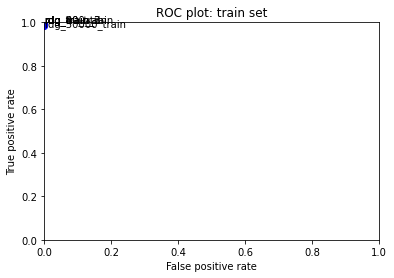

In [57]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train]
fits = [rdg_performance_train,rdg_2_performance_train, rdg_3_performance_train, rdg_40_performance_train, rdg_800_performance_train, rdg_50000_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [16]:
# ols_predictions = ols.predict(X_train)

In [17]:
# false positives

# print("Examples of false positives:")

# import random, time

# for i in range(0, len(ols_predictions)):
#     if (ols_predictions[i] == 1):
#         if (X_raw_train.iloc[i]['any_toxic'] == 0):
#             if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
#                 print(i)
#                 print(X_raw_train.iloc[i]['comment_text'])
#                 print('* * * * * * * * * ')


Examples of false positives:
8
Once again, I disagree that it is relevant and I am free to edit the article just as much as you are.  (Angry Mastodon! Run!)
* * * * * * * * * 
12
Could a section be added to the milan bit 

Just thought the fact that the 2011/2012 season was the first in which he didn't win the league may be an interesting fact which could be added to the ending of the current season Milan section.
* * * * * * * * * 
74
numerous evidence on the issue 

The Himmler doctor's claims are only one of a myriad of evidence on the issue. For example, Regev in his recent book (page 184) brings a quote of a recorded interview with Ian Holm , the Danish refugee minister. This also confirms the allegations towards Bernadotte which were elaborated in the previous books cited.
* * * * * * * * * 
156
who happens to be the administrator who blocked me, his name isn't even attached to the quote. We have a whole section in the guidelines with over a dozen quotes culled from actual deleti

1954
But here's the thing history and time travelling (which you did show a citation to), travelling to the earth's centre, creation of the universe, the future, parallel universe, the ultimate fate of the universe, dystopias and utopia (which you did show a citation to), telepathy, intelligence amplification, invisibility, psi powers and psychic phenomenon (as well as the three themes beneath it), resizing, shapeshifting, teleportation, apocalypses or world wide disasters, posthumanism, the ultimate fate of the universe and the kardashev scale, floating cities, underground cities, walking cities, the age of post-scarcity and domed cities can be used in fantasy, there for not exclusive to science fiction. Alien invasions and artificial intelligence (amongst the other themes that are on the page that I can't think of) can be used in horror and are there for not exclusive to science fiction. And as much as I hate to (as we'd be stuffing up the article even more so, but it'd be for it's o

Stuff like that is often a remnant of ye olden days of Wikipedia, when there was far fewer rules and far, far fewer people roaming about looking for opportunities to enforce them.
* * * * * * * * * 
3404
Oppose Seems pointless.
* * * * * * * * * 
3486
I've just been investigating page hits for the links from the main page, whilst doing so I noticed a couple of duplicates ... and before you know it came to the conclusion that this line of links Overview · Editing · Questions · Help    Contents · Categories · Featured content · A–Z index is uneccessary. About,Help,contents, and featured content are already linked in the sidebar, the editing tutorial can be accessed from intro and about, that leaves questions,categories and a-z, which could be integrated into the side bar. This would bring the content up by one line - not much but an improvement for readers to get more 'meat' right away.
* * * * * * * * * 
3559
"

 WT:HNB#Attention_everyone 

Chat © "
* * * * * * * * * 
3584
Can you pleas

"

 Carbon-Carbon 

Perhaps that could use a little more explanation, then. Carbon brakes  are carbon on carbon, in that the material is used as both brake pad and disc. However, the material used is a carbon-carbon composite: carbon fibres set in a carbon matrix (see Reinforced carbon-carbon for more technical stuff). It could actually be either reason I suppose, but they are normally referred to as 'carbon-carbon'. The topic is discussed in greater detail further down the article - I've put a '(see below)' at the first appearance of 'carbon-carbon' which links to the 'Technical innovation' section further down.

Thanks for all the further edits - I've only reverted one (sorry! -)). The direct quote from Michael Scarlett about the MRD/merde connection shouldn't be corrected (ellipsis is acceptable), even if wrong grammatically, since that's what he wrote. Unless I've misquoted of course, which I'll check when I can get my hands on the article.

One question - I don't understand why in

6647
Cheers Ceoil. I much liked your edit on the Standing Madonna. Only here for a few days more (. Back next year maybe... I want to get the Chroniques de Hainaut miniature in, as well as the embroidery I scanned and uploaded to Commons from the expensive Campbell & Van der Stock I scanned the Justice  from. 

Kind regards
* * * * * * * * * 
6648
You're gonna have to protect this page. You won't be satisfied with how much a block slows me down 

117.201.43.10
* * * * * * * * * 
6707
"

 A barnstar for you! 

  The Real Life Barnstar hey buddy thanks for what you do here, but what do you know about chillout music  and this artist? this guy is world famous in chillout music and deserves a page on wiki ,you have to give me a reason of why you want this page to be deleted ? this guy  has 2 tracks on buddha bar series and has more than 50 releases you want to delete this page go ahead but with people like you wikipedia will never expand!   "
* * * * * * * * * 
6769
"

citation requests

In

7406
"

WikiProject SpongeBob SquarePants May 2007 Newsletter

 WikiProject SpongeBob SquarePants Newsletter May 2007 Volume 1, Issue 9


{| style=""border-spacing:8px;margin:0px -8px"" width=""100%""
|class=""MainPageBG"" style=""width: 45%; border:1px solid #cef2e0; background-color:#f5fffa; vertical-align:top;color:#000""|

 AboutThe WikiProject SpongeBob SquarePants newsletter is a monthly newsletter regarding the project.  writes and publishes it. If you are interested in helping with the newsletter, please see the WikiProject's talkpage. Interviews was interviewed regarding the project. His responses are as follows:
1. What is the WikiProject best at?
Letting members know how to help
2. What could the WikiProject improve upon?
More talking between Users about articles
3. What are some guidelines you believe the editors of SpongeBob SquarePants articles should follow?
Standard Wiki
4. Where do you help the Project and/or SpongeBob SquarePants articles the most?
Watch for errors in

9839
Bens Large Breasts

Hi, I was just commenting on Bens Large Breasts. He knows me, he knows I'm only joking around -)
* * * * * * * * * 
9872
"

I dont want an edit war.  Anytime I try to do anything I reported for evading, my comments are ""redacted"" and I get reported. Y is no 1 policing HC?  70.108.133.81  "
* * * * * * * * * 
9930
"
 @TheRedPenOfDoom: I suggest you take your pretentious, audacious, holier-than-thou attitude and your exaggerated self-opinion and shove them into the same orifice I already told you to shove your keyboard into. I'm sure there's still plenty of room. But thank you for conceding that every editor here is equal in standing to yourself. Now if you'd only treat them as such this project would be a better place for everyone involved. ''''Let's talk about it "
* * * * * * * * * 
10003
" The Wikipedia criteria is flexible citing new wikis as links to ""normally be avoided"" but it is not an absolute block. A more comprehensive look at these Debatepedia.or

massive producer of electronic goods and cars, major ship builder,
* * * * * * * * * 
11162
"

Once again, User:EconProfessor has insisted on wholesale removal of sourced content because it apparently conflicts with her opinion of Donna Hughes. EconProf summarizes the edit as follows:

""Removed paragraph that violates NOR, POV. False speculation that email was related to prostitution hearings & was cause of CSPH delay. Sources show CSPH delay was caused by zoning & licensing probs.""

Sorry, but just because it may reflect negatively on Donna Hughes does not in itself make mention of the incident POV. The sourced articles clearly state that negative attention was brought to Megan Andelloux and the CSPH through the efforts of Donna Hughes. A zoning battle over the CSPH immediately followed, and the zoning issues may or may not have had their own merits. The degree to which Donna Hughes emails and negative publicity played a role is a matter of argument, and I have be quite careful to p

12085
So far so good, it looks like a long episode! 

I hated the south park movie because of all the songs. I want the simpsons movie to feel just like a long episode. so far it looks like it will happen with the scene where the people break into the house. namely the off screen dialogue. anyone agree? JasonX80
* * * * * * * * * 
12108
Dear Lucy,I love you.I will be sending you a rose soon.If you throw it away Lucy I shall kill you,because you ARE MINE LUCY MINE.............
yOU ARE MINE AND YOUR GRANDMOTHER CAN'T TAKE US AWAY FROM EACH OTHER LUCY
aND I WILL NOT LET ANY ONE ELSE HAVE YOU LUCY MY LOVE..

i love you lucy i love you

This user is currently blocked. The latest block log entry is provided below for reference: 

07:34, 25 April 2011 Materialscientist (talk | contribs) blocked 92.21.249.175 (talk) (anon. only, account creation blocked) with an expiry time of 31 hours ‎ (Disruptive editing) 
This is a talk page. Please respect the talk page guidelines, and remember to sign yo

12895
My page: Alex Kenrick 

Check out the new page and let me keep it until I can post a link to the youtube video
Thank you
* * * * * * * * * 
12907
My comments are often deleted for no reason.  hence copy pasting and lack of signature though containing name.   johnHistory
* * * * * * * * * 
12909
Defaultsort bug fixed 

 Defaultsort bug fixed.
* * * * * * * * * 
12961
Observations from the Afterlife 

As I sit here, cursing the bastards who blocked me, I ponder over the finer points of this case. Actually there is only one.  (or RyanLupin - whatever you're called now): to stop being harrassd do two things. Remove your mugshot from your user page and get rid of those links to social networking sites. Do you wonder why people have been texting you amongst other things? It's because you make it so easy. From one look at your user page, they know where you live, where you study, what you look like... it doesn't help at all. I hope your harrassment does end soon. Follow what I've said a

14191
"

AFC Creation
Please take a look at the articles created that were deleted.  Some of the sources I had previously used were not what they consider to be reliable sources.  After the non reliable sources were mentioned to me, I stopped using them.  I started to only use sources that appeared on google news or on google books.  I have even gone to the reliable sources noticeboard to see if sources were good to use.   The SPI wasn't frivolous as a number of editors were previously investigated as being members of https://en.wikipedia.org/wiki/Wikipedia:Sockpuppet_investigations/Papaursa/Archive     Other admins (. St★lwart111) have stated that there were problems in WP:TAGTEAM .   specifically    Most of my articles are about individuals who were are notable via wiki standards such as African Americans sports players during segregation James “Pappy” Ricks, Olympians such as Thomas Martin (judoka) or National Champions such as Howard Fish.   
With 140 articles about 9 have been del

15692
Good catch 

...on the deleted article. Sorry you go so much grief an ANI for it. I've commented there . Nobody Ent (Gerardw)
* * * * * * * * * 
15702
"

 General message 

Hi, Tournesol! This is just a general message you don't have to reply to, but it would be greatly appreciated if you do.

I know what I have done at SVWP, and I have done many things wrong there. And yes, I have been trolling a few times. The problem was I didn't even think about a permanent block. I simply thought that if you were contributing constructively (no vandalism), you are welcome. But, I should've read sv:Wikipedia:Det är ingen rättighet att redigera på Wikipedia (English: Editing at Wikipedia is not a permission). If I had thought about my behavior at SVWP, I would probably have ""skärpt mig"" (pulled myself together?) and really shown who I really am.

I am a normal user, but I just want you to know I am completely aware of my behavior at SVWP, which caused my permanent block. But please, please l

17128
|listas = Yury of Moscow
* * * * * * * * * 
17158
I'm 27 and have Post-traumatic stress disorder 

I was kicked out of the milatary for being a gay transexual , and my 2 and half daughters recently passed away in a skiing accident in Hawaii, so excuse me if I make SLIGHTLY incorrect edits on wikipedia.
* * * * * * * * * 
17342
Agreed; cut.  (Talk)
* * * * * * * * * 
17348
User: Random USCG Webmaster
* * * * * * * * * 
17384
"
Thank you! -   Talk "
* * * * * * * * * 
17532
My birthday is today I turned 20  Nevaya
* * * * * * * * * 
17605
"

 Merger proposal 

Basically both articles describe the same thing/process. For me, ""devoré"" is the term that most fashion/textiles people use or know, although ""burnout"" is also used quite often for the same process. However, I would suggest burnout (textiles) is preferable to the current Burnout (clothing) title of the other page if ""burnout"" is deemed more appropriate than ""devoré"". They certainly need merging, although the question 

18788
Response to your post about Iryani 

Your silly post on my talk page demonstrates exactly the POV pushing that is mocking the integrity of the article. Forcibly abducted is absolutely ridiculous especially when the parents had died and he was adopted to be taken care of. I don't even think the original article even had those terms and if it did, it would be POV. You want to post 7 paragraphs of a story (MUCH OF IT PLAGIARIZED) that is attributed to Abdul Rahman by some person who learned from some other person who claims to be the grandson of the sister of a man that the sister has not seen for decades and who lives in a country they have no access to??? ABSOLUTELY LUDICROUS. The Haaretz's source (Mizrahi) isn't exactly an authority source on Abdul Rahman's life, family sources in Yemen are more credible, but the best source is an autobiography or written biography by someone who knew him. If you want to write 7 paragraphs on his life story, then it should be from a credible, rel

Hi there. I noticed your tagging of Gideon Encarnacion as A3 (no content). Please note what it says on Special:Newpages: ""articles should not be tagged for speedy deletion as having no context (CSD A1) or no content (CSD A3) moments after creation."" You tagged this article three minutes after creation. The reason for this note is that new users may not understand that their contributions are live as soon as they hit ""Save"". After a few minutes (at least five, I'd say), it's OK to tag the article. Cheers,   "
* * * * * * * * * 
20221
"

 Brain crucial 
""Because virtually all living organisms require their brain to carry out basic functions"" is simply untrue. Most animals do, but animals make up a small percentage of ""most living organisms."" No plant, protist, fungus, or moneran has a brain to my knowledge.  —Preceding unsigned comment added by 69.121.0.142   "
* * * * * * * * * 
20266
"

 Hello 

I am very upset that you reverted the changes I made on the page for Niceville, Flo

21405
Has been delisted per consensus.
* * * * * * * * * 
21464
This incident has been reported to the Biographies of living persons/Noticeboard.  Here I simply note that the thrust of Vabio1's argument is the claim that the facts supported by the biased campaign website citations are true.  VaBio1 urges readers to verify them for themselves, i.e. do original research.  This is contrary to Wikipedia policy.
* * * * * * * * * 
21470
I'm very glad to hear that.
* * * * * * * * * 
21490
The artists you added to the infobox for The-Dream do not fit the criteria at Template:Infobox_musical_artist#associated_acts. Please review it and explain why your additions should be accepted, because they seem like one-time collaborations rather than frequent collaborators.
* * * * * * * * * 
21531
Don't spam wikipedia articles with links to racist websites.
* * * * * * * * * 
21552
yo yo yo ! ceat evan gray heyhey dawggggggg david suzuki....umm what i changed it to is right okay?
* * * * * * * * * 
216

22735
"

Speedy deletion of Alex mcdonald
 A tag has been placed on Alex mcdonald requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a person or group of people, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not assert the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable, as well as our subject-specific notability guideline for biographies. 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the article (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the article's talk page explaining your position, but be aware that once tagged for speedy d

24956
September 2006 

  ~a ( • talk • contribs)
* * * * * * * * * 
24964
Cobden, Ontario

Hello, I'm a moderate user of wikipedia. My Opus for this site has to be the article I wrote on Cobden, Ontario. This is my home town and I did a lot of research into it's history and everything so that I could make a good article on it. I have received a lot of comments from people in my town about the article and a lot of them have told me they learned things that they didn't know before. Recently a user named Bearcat has merged a lot of stub articles into the article about their region. I'm not sure what the policy is on this. Most of the articles were about very unnotible places (mclarens settlement being the best example). But I'm a little unclear on why he seems to insist on merging cobden aswell. The article was over 10,000 words long. I know that there doesn't need to be articles on everything on earth but, and I realize I may be the minority on this, it seems like towns  should have thei

26478
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are a few good links for newcomers:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome! 

It is felt that the article you created at Zach peters is not suitable for a Wikipedia article, which must have a notable subject and be verifable. I have moved it to 2000
* * * * * * * * * 
26526
"

 Coat of arms 

Something that I've always wondered. Is the person in the coat of arms a guy or a girl?  | Talk "
* * * * * * * * * 
26572
Agreed. 85.97.5

28191
(UTC)
Note, with the admission of Bideford reserves and Merton from the Kingsley League to the N Devon League, the N Devon statement regards the Kingsley League as the same standard as their Division One. -   10:52, 15 June 2008
* * * * * * * * * 
28402
It was just an inertion mestake, could happen to everyone. The official site and the official document are two different things, at least I have sites where it is pointed so. You, where is your prove that the flag should be removed.
* * * * * * * * * 
28472
"

Image Tagging Image:Destroyer.JPG

 This media may be deleted.

Thanks for uploading Image:Destroyer.JPG. I notice the 'image' page currently doesn't specify who created the content, so the copyright status is unclear. If you have not created this media yourself then you need to argue that we have the right to use the media on Wikipedia (see copyright tagging below). If you have not created the media yourself then you should also specify where you found it, i.e., in most cas

29921
Thanks  for the info. The Wikiproject will be an effort to create a new category of games that require only common materials (i.e. dice, playing cards, pencil and paper). Is this legal?
* * * * * * * * * 
29929
"

 Clan lists and maps 

I noticed this title, and found it unfit (I didn't see anything relating to maps). I'm going to shorten it to Clan lists, or something of the like. If there's a set reason for the ""and maps"" part, then by all means, revert, and just leave a note here, explaining why.  "
* * * * * * * * * 
29950
":::::Geoffrey - far from ""crediting [you] with changes that [you] didn't make"", what I said above is precisely accurate. It was you that changed the wording so that it appeared the creationists were making a claim about the acceptance of evolutionary theory. You changed it from (fact) this is because to (claim by creationists) they say this is because. No wonder you are getting confused. But Robert Stevens has it exactly right. My suggestion that it mi

31372
There were a few issues with the existing references anyway (some inconsistencies in included elements, notably). Citation templates also generate COinS data that can be gathered by appropriate tools.
* * * * * * * * * 
31421
03:27, Jun 23, 2005 (UTC)
* * * * * * * * * 
31479
Why do some editors talk about stage names, as if every name is a stage name - it just shows further lack of attention to subject matter, indicative of the 'let's move form a perfectly fine title - because that's gotta be our purpose'  actions.
* * * * * * * * * 
31545
Influences 

I removed the sentence 'Another likely influence is the band Guster.' based on weasel wording and lack of a citation. If someone does find a citation, I'd suggest restoring it somewhere more logical than at the end of a paragraph describing how their first single charted.
* * * * * * * * * 
31660
"
That doesn't make having a tangential article copy pasted into NST a good thing. It's strong enough to stand alone, and you could prob

33075
"There is a version where the last line goes ""there's none so rare as can compare with the voice of the infantry"" (which similarly goes through the ranks). I have sung as a campfire song at historical reenactments but I can't easily attribute that version.
176.252.226.165  

"
* * * * * * * * * 
33081
Exactly. Even if the actual intent isn't to promote the petition that's the reasonable impression this gives (as well as the effect).
* * * * * * * * * 
33115
04, 23 January 2009 (UTC)

 Hi 

I'm not going to challenge you or anything, but I really don't see how any of this is your business.   18:
* * * * * * * * * 
33133
"

 You deleted page ""Assassination plots in the Three Kingdoms'' 

05:45, 28 June 2012 Sandstein (talk | contribs) deleted page Assassination plots in the Three Kingdoms (Wikipedia:Articles for deletion/Assassination plots in the Three Kingdoms) 

Assassination plots in the Three Kingdoms contains the list of assassinations plots of a novel named 
Romance of th

34923
vandal warning 

Whomever you are, you are guilty of vandalizing my page and possibly harrassment as well, as is evident on my page history
* * * * * * * * * 
35052
"

 Removal of Specious content 

I have read completely the source cited to say that Che was in the ""custoy"" of Félix. The citated material does not substantiate this and has been removed per WP:BLP and other policies. Please do not reinsert this.  "
* * * * * * * * * 
35119
"

 Speedy Deletion of ""Girl Power (Video)""  

Hello, 

I recently established a page for Sadie Benning's video ""Girl Power"". I've been notified that the page was challenged for its presumed insignificance (not enough ""notability""). Considering the fact that feminist artists have been excluded from the mainstream art establishment and essentially omitted from history, I understand why one might thing a page dedicated to one of Sadie Benning's video MIGHT NOT have ""enough notability"". However, I would easily respond by mentioning that AL

36569
formating problem 

The value is supposed to be 1777MeV/c2, but the template makes it look like it's three orders of magnitude smaller. I don't know how to correct this.90.179.235.249
* * * * * * * * * 
36598
How does one get Eastside Sun  newspaper deletion undone? 

Hi.  A bunch of self-appointed censors winnowed, then deleted, the article on a newspaper in Washington State called The Eastside Sun.  How do we determine the identities of the people behind the screen names?  This was a clearly orchestrated effort and it needs to be exposed in print.  We've spoken with Rolling Stone and they want us to get the lowdown.

Thanks!
* * * * * * * * * 
36603
Chart Position 

It has peaked at no. 52 on the BBHOT100 so far, as can be seen here  so whoever keeps changing the main article, could they kindly stop, thanks.
* * * * * * * * * 
36608
I started a consensus discussion on adopting your and Eric's infobox on Wikipedia talk:WikiProject Aircraft. Please voice your opinion! -  Burninat

38484
"Here it the closest thing I can find to an OFFICAL script on the web.
http://www.intriguing.com/mp/_scripts/mp-holy.asp
I also look at several trasciption. All had the word as ""naughty"".
I have seen a published hardcopy once apon time (about ten years ago in a used book store in Loundon) but was unable to locate copy for a full bibliographic refrance. Unless anyone can come with a refrence that says other wise, I vote to change the entry.

"
* * * * * * * * * 
38492
"

 Gameplay 

There is much more info on the Starbound Wiki if anyone is interested, I have created the ""Playable Races"" section also.    ""Aven"" Zhang"
* * * * * * * * * 
38524
Please stop.  If you are going to make accusatory statements about a living person in an article, please be sure to WP:CITE verifiable and reliable sources when doing so.  Thanks.
* * * * * * * * * 
38572
Pro-property libertarianism is a flavor of anarcho-capitalism. Go play with your friends.
* * * * * * * * * 
38575
"
That was a very 

40397
I reckon there is an argument for it  - it is an interesting part of the total package. It's much easier to read here than the version printed in the booklet/sleeve.
* * * * * * * * * 
40529
has 48 articles, most of them
* * * * * * * * * 
40584
Perhaps a Life is Needed 
Come on!  Do you just hang around Wikipedia, like a vulture, waiting for someone to finish a page, just so you can go in an vandalize it?  I do not appreciate the gutting you did to the article I created on H. Wayne Holm, before I even had an opportunity to come back and finish the article.  This is an issue of great importance to me, and your immediate intervention leads me to believe that you may in league with those who want this issue covered up.  You would do well not to do anything to further that impression, because I promise you that EVERYONE involved in that cover-up, is going to to end up in prison!  Word to the wise cowboy.
* * * * * * * * * 
40651
The top science advisor in the UK made a point that sk

42277
"
I wasn't sure if ""Will Bareback"" was an actual past account of Will's or not, so I was going to ask him about it before posting the final RfC.  The other edits the IP has made appear to be helpful, so I don't have a problem with the IP helping out.  Will, do you think one possible reason someone may be using an IP is to avoid being the recipient of threatening behavior, as occurred today to Keithrob?   "
* * * * * * * * * 
42300
I think the 2004 remix of the song was not done by Cam'ron featuring The Game and Jim Jones. I believe that song was on Jim Jones' LP, On My Way to Church, and featured Lil' Flip and The Game while an alternate version replaced Flip's verse with a new one by Cam'ron.

Could someone please fix this, that'd be great.
* * * * * * * * * 
42333
Raptor Jesus 

Raptor Jesus is the prophet of the internets and has come to us to enlighten us about the gospel.
* * * * * * * * * 
42336
i saw it it it totally not like the pc version it has a story and for each le

44020
I have to say I agree with some of the above and disagree with other bits, but I think that  has it right.  Placing this article into a category inherently does just that, it categorizes it into a topic heading.  But adding a navigational template at the very bottom is not characterizing anything, it is simply a tool for other editors, in other words, if your interest has been piqued after reading this article, then here are some others that might interest you.  So I'm going with no on Category:Cult related books, and yes on .   .
* * * * * * * * * 
44034
"

Arbitration enforcement action appeal by Yossiea~enwiki

Procedural notes: The rules governing arbitration enforcement appeals are found here. According to the procedures, a ""clear, substantial, and active consensus of uninvolved editors"" is required to overturn an arbitration enforcement action. To help determine any such consensus, involved editors may make brief statements in separate sections but should not edit the sec

45544
Re: warning 

It wasn't a personal attack. I just want him to stop mindless reverts. I have nothing to do with anyone personally.
* * * * * * * * * 
45607
"
Try reading the US Census Bureau or the CIA factbook entry. Both say, income inequality is rising! I am not the one nit-picking through articles to back up a conervative agenda-I am the one trying to quote the CIA factbook-hardly OR. I have started an RfC-let's get some other users involved!  "
* * * * * * * * * 
45625
UNBLOCK - the question of integrity is not an issue for moderators?

Regardless of the WP:TRUTH that you seem to think you hold, Wikipedia works on a) WP:CONSENSUS, b) reliable sources, and c) a collegial editing environment. Your edits clearly show you're harassing an editor that you disagree with. You will not be permitted to continue that way. Please also note: stop typing in ALL CAPS - it's considered to be shouting, and that doesn't go over well on the internet (talk→ BWilkins ←track) 

Regardless of the W

47485
Help! 
I seem to have made a complete mess of the Hull Trains article while trying to change the tables, please revert this!
* * * * * * * * * 
47487
Scleroderma 
If Scleroderma is a genetic diseases? my mother has the diseases, what are the chances that i will have it?(i mean is it dominant diseases?) what pecautions should i take to avoid the diseaes?````
* * * * * * * * * 
47500
2011 (UTC)
I've changed it over to another free-use image. We did use a crop from the same base photo once before, but the crop wasn't very good - I've recropped, and tried to clean it up a bit. -   10:02, 2 April
* * * * * * * * * 
47550
"
 Hello. You might check out Fraunce's ""A Brief and General Comparison of Ramus His Logic with That of Artistotle."" It takes the form of a debate between two Cambridge pedants, with Sidney as the judge.   "
* * * * * * * * * 
47559
If you don't know the standard measures by which drivers are gauged in F-1 racing, what the hell are you even doing editing F-1 related

49138
I totally agree with this. How is it that screenshots from the series can be used for characters and the like. Someone seriously needs to tag this page, not only for the pictures, but for some unverifiable information. NOW! 209.240.206.208
* * * * * * * * * 
49141
Update
Taxonomy of Banksia integrifolia and Banksia integrifolia#Taxonomy are in my opinion done. I'll be moving on to distribution and habitat tomorrow. Thanks for your patience. ;-) Hesperian
* * * * * * * * * 
49174
"

Re: this comment, please see Scientific theory & WP:WTA. Please also read WP:V & WP:FRINGE. Unsourced additions pushing pseudoscientific fringe claims will be reverted as a matter of course. ''TalkStalk''(P) "
* * * * * * * * * 
49179
"No, you're wrong. They don't hate him, they love him. And Iraq: He called the war in Iraq ""genocide"", and the re-building by America he called ""healing"" and ""giving"". That's what he called the ""perfect cause"". But I'm sure, you understood that. You just wanted to

50767
Hi World! Hows it going
* * * * * * * * * 
50808
Wow, that is how to deal with it!  I totaly agree, no good came of this... it is sad... why can't people live together in peace, and let everyone contribute?
* * * * * * * * * 
50825
Wireless Computer

It is interesting that the State of Oregon of the United States (as of 2005) has the greatest number of wireless computer communications for the Internet, and the British do not have it.  Even Starbucks, the coffee company, offers wireless computer communications on their coffee lands (grounds).  U.S.A. does something and that is American Know How.
* * * * * * * * * 
50836
and i belive you are a lier since you don´t know nothing about Iran. Persia was the term europeans and the north-africans used it for the Aryan country. You are either NisarKand or Pashtun65 who also claimed to have studied history. The people self called themself Eironi, Erani. Ossets still call themself Ironis.
* * * * * * * * * 
50872
"

 That userbox.... 

Hell

52447
The number is 12. 10 outright and 2 shared. Do not fudge the history any more. You cannot argue with the NCAA. Count if you will.http://www.ncaa.com/history/football/fbs
* * * * * * * * * 
52594
Issue is now mostly resolved. Thanks to J. M.
* * * * * * * * * 
52602
.
 This is for units created and used primarily for humour value only. If the unit sees widespread usage, at least within its specialist field, it properly belongs in list of strange units of measurement, not here. It is conceivable that a unit originally created for humour value may eventiually see serious usage
* * * * * * * * * 
52624
"

 Kazi Nazrul Islam 

Hi Blnguyen - as you are a key contributor to this article, I would like to like to inform you of the changes I've made. Please don't take offense at the removal of data. My reasoning is this - speaking in context of the overall article, why risk removal of FA status. Its a subject on which there doesn't seem to be as many sources available. As a solution, I don

54401
Edited section entitled FATE and add a new section entitled FURTHER INFORMATION to specifically showcase images of the ship that can be viewed on the State Library of South Australia website.  The location of the wreck is given as South Neptune Island based on the latitude & longitude advised in the Australian National Shipwreck Database - some other references state that the ship ran aground on North Neptune Island.   cowdy001
* * * * * * * * * 
54422
"36, 5 November 2014 (UTC)

Meagan Meagan Hey Meagan, I think Kathleen covered most of the stuff I was going to say. But in your third guideline, theres a sentence that begins with ""Choosing: choosing"" I think it's a great point, but I'm not quite sure that the way that it is worded fits with the rest of your guideline. I would either make ""Choosing"" stick out a little differently, or just get rid of the ""Choosing:"" introductiong to the sentence and begin it with ""Choosing the more..""

Overall I think you guys have all done

56525
I will propose a modified lead based on the discussion and the current article status, ok?
* * * * * * * * * 
56622
User:Magneil Max 

Read my userpage,
* * * * * * * * * 
56630
"
Swapping images, so leaving the Helton image here.  talkcontribs "
* * * * * * * * * 
56634
. That would give me have some slack
* * * * * * * * * 
56710
Regarding edits made during November 22 2006 (UTC) to Italian Renaissance
Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia. If this is an IP address, and it is shared by multiple users, ignore this warning if you did not make any unconstructive edits.
* * * * * * * * * 
56906
.- both are Wikipedians who are going to get owned
* * * * * * * * * 
56923
Keep article rather than merge.  After a quick search, article can easily be expanded in regards to out of u

58490
I agree with Kamosuke on some points, however I still prefer Sir Edgar's version over Kamosuke's although not perfect.  I request Sir Edgar's version to be modified to mention Western influence before and under the sakoku policy.
Here are my thoughts in detail....  I agree with Kamosuke that China is similar to the Roman Empire, with respect to culture, politics, literature, arts, and religion, as well as its influence towards its surrounding nations.  More specifically, Luoyang (洛陽) and Chang'an (長安) are similar to Ancient Rome.  However, you cannot eliminate the mention of Korea.  From the dawn of historically recorded Japan, until the fall of Baekje, Korean influence was greater than Chinese influence.  Then there follows a period in Japan where Korean immigrant families remain important while Japan looks to China for influence; but eventually these families assimilate and dissolve into Japan.  A period of greater Chinese influence continues for at least 9 centuries.  However 

60350
The Hate ==
Why all the hate???

== Re:
* * * * * * * * * 
60396
"
Not sure what is being requested here.  Per the template's instructions:
This template must be followed by a complete and specific description of the request, that is, specify what text should be removed and a verbatim copy of the text that should replace it. ""Please change X"" is not acceptable and will be rejected; the request must be of the form ""please change X to Y"".
  "
* * * * * * * * * 
60405
"

 
You have been blocked from editing  for vandalizing . If you wish to make useful contributions, you are welcome to come back after the block expires. ~  "
* * * * * * * * * 
60487
"

 Extensive Welfare System? 

Presently, Singapore can be politically analysed as a democratic socialist country and has an extensive welfare system, although de facto it has a dominant-party system. 

We have an extensive welfare system? I know we have no unemployment monetary benefits, no disability monetary benefits, no eldery m

61560
~Welcome. Nice to get thanks for declining a request ;).  Humbug!
* * * * * * * * * 
61689
Is there an article about that type of raw file?
* * * * * * * * * 
61774
"

 The 222's and gangsters 

For your information, the gangster story about the 222s second 7"" is true and has been reported in many newspapers like Hour and Mirror and the Gazette  "
* * * * * * * * * 
61778
This all seems rather alarmist for a wikipedia entry on nipple piercings. Every piercing has its dangers but this entry is probably 50% warning about the possible medical problems that could arise. What are the percentages of people who end up with these symptoms, it almost feels like all people with this piercing are affected. Which can't be right.
* * * * * * * * * 
61886
"This page is majorly biased ==
This page has a negative bias toward Stormfont. For example, it labels the website as a ""hate site"" and ""neonazi forum."" Although it is possible that some Stormfront members would characterized their views

63208
"

 Your edits at Mansaf 

Greetings, at mansaf you made edits to emphasise the claimed ""national dish of Jordan"" aspect of mansaf, and remove the (widely noted in books) Palestinian participation in the dish. You also added inappropriate WP:POV comments such as ""the pride of Jordan"". I have removed those edits, and am making some edits to make the history of the dish (and its politics) clearer. Please do not make edits based on personal/national preference, please ensure your edits are supported by WP:Reliable sources (so not cooking sites, blogs), and whenever you edit ensure you use the WP:Edit summary to explain your edits. Try hitting the ""History"" tab on the page and note I explain each edit I make, while your edits are unclear because you provide no explanation. Thanks for your time,   "
* * * * * * * * * 
63234
"

 fair use image reduction 

Wiggy, I saw with a number of your edits that you removed  tags from fair use images. As an example, this is one of your edits

64438
No, it isn't a remix...Do you have a source for this?  50 Cent has stated via Myspace bulletin that it will be on the album!
* * * * * * * * * 
64544
Welcome!

Hello, Nerhesi, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page and How to develop articles
How to create your first article (using the Article Wizard if you wish)
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question on this page and then place {{help me}} before the question. Again, welcome!
* * * * * * * * * 
64632
There’s definitely nothing in the original books to suggest that their fantasy world has anything to do with

I just had a idea for a wiki. Wikireligion. Cantribute if you want to. I just thought you might want to because you could write a lot on hinduism there.
* * * * * * * * * 
66058
"
""Virtually no interest"" in current application, but ""very influential"" in a historical sense where he laid the groundwork for present-day clinical psychology. It is true - Freudian faculty at universities are generally few and far between. Maybe the wording can be adjusted to clear up any POV concerns, though.   "
* * * * * * * * * 
66067
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me. e  work
* * * * * * * * * 
66111
Neurophone

Actually, there's no reason that this should even be on wikipedia. The science behind the concept is bad, the device itself claims to do almost nothing, and nothing

Ganguly family (films): Copyvio Gallery 

Boss, these pix were already uploaded on WP. What made them copyvio? Please, advise. -   - please, answer to my talk page.
* * * * * * * * * 
68258
ADDITIONALLY  YOU ARE REMOVING SOURCED information.  If you continue to do so, you will be reported.  Everything is sourced from a VALID/REPUTABLE site.  IF YOU CONTINUE TO REMOVE THE SOURCED INFORMATION, YOU WIILL BE REPORTED
* * * * * * * * * 
68302
"

 Info and links 
 The Cause for Invasion
""The goal was to remake the political landscape—to drive out the Palestine Liberation Organization and install a right-wing Christian Lebanese leader prepared to sign a peace deal with Israel. But Operation Peace for Galilee ended in failure."" 

""Israel launched operation ""Peace for Galilee"" and invaded Lebanon in 1982 in what was sold to the Israeli public as a bid to drive the Palestine Liberation Organization back from the northern border. Sharon went on to drive the PLO out of Lebanon and to try to i

69719
"

George Noory Radio Talk Show Oct 13, 2004
Thanks.
On Oct 14, 2005, at 3:04 PM, ANTIGRAY@cs.com wrote:
Hi Jack,
They were talking about you and Uri Geller and others involved in doing mind control stuff mostly. They should repeat the show this evening in your area. They do that here every night on the local radio station, replaying the show from the night before just before the new show comes on. I found the following article on a blog. The guest on C2C, Peter Lavenda, was talking about some of this.
Art

Remind me who Lavenda is. I may have met him in Brussels and Jerusalem. Is he a chemical physicist?

Friday, October 07, 2005
                          The Colour out of Space      

I dreamed that I was in the grasp of a great and horrible paw; a yellow,hairy, five-clawed paw which had reached out of the earth to crush and engulfme. And when I stopped to reflect what the paw was, it seemed to me thatit was Egypt. - HP Lovecraft

This is only a test

At 5:05 on November 22, 19

71481
"

 Particle Gravity? 

The current article says this theory is commonly called (in the scientific community) ""particle gravity"". Does anyone have a reference for this?  (I've never heard the term ""particle gravity"" used to describe this kind of theory.) "
* * * * * * * * * 
71493
"

I understand your ""bipartisan"" theology. However, my studies were secular from a secular college. After many years of religious studies at a secular university, can you please explain how I am incorrect in my thinking? I am approaching this clearly with you; I would appreciate a clear response and not directly pointing me to be a ""fundamentalist Christian""."
* * * * * * * * * 
71543
"

 Lasvegasflash ban 

Just a few comments on this action.
First let's say I have been in this guy's boots. Admins start revertinng your edits with no explanation and no explanation of who they are or their capabilities. After participating in other forums and various social activities around the Internet one lea

72666
I demand that article Turks should redirect to Turkic peoples for the same reason Arabs redirects to Arab people and Germans redirets to German people.
* * * * * * * * * 
72686
"Semantic complaint===
The headings of this discussion are potentially misleading.  I eventually figured out we're talking about ""cover"" in the sense of ""treat,"" ""include,"" or ""write about"".   However, cover can also be taken to mean ""suppress,"" ""bury,"" or ""censor"".  That is, those who might be favor of not covering Connolley's desysop in his WP bio might themselves be accused (wrongfully or otherwise) of covering they desysop.  Just a thought.  

==="
* * * * * * * * * 
72715
Lol!  Yeah, just a few books ;)  Although I'm now getting nervous about whether I have enough!  Anyhow, many thanks for the very kind comments and confidence (from everyone) and thanks again for waiting for me )  On the other thing, I'm not sure I'm qualified to comment so I won't; I should probably have checked more cl

73671
Im honoured and suprised I am the creator of this page as a die hard Hull City Suporter it gives me great pleasure to welcome you here on the eve of our most succesful season in my life time. I hope to record the forth coming seasons events in detail as they unfold. I intend to date my entries and will next post squad changes and any other details I can for the forth coming season. I intend to keep this entry brief as I hav only just discovered this site!!
* * * * * * * * * 
73685
I was talkin to skillsomega. that's mark! not you! 87.209.195.148
* * * * * * * * * 
73786
Then dont come here if you dont like it?! 31.209.16.177
* * * * * * * * * 
73853
Thanks John, I appreciate your thoughtful words. )
* * * * * * * * * 
73864
"
There is no POV problem, If you asked any person that is completely uninformed in Gamergate or 8chan if that article is biased one way or the other the answer would most likely be ""No"", Also, My comments were not out of line, Just because you don't agree w

75291
Yeah I think singing should be limited to only about A1-C2 at the lowest and probably C8 at the highest. Cause Mariah sang G#7 live so easily. She probably could go higher its just that higher than that just sounds like sqeaks ya know? Musically some notes are too high or too low to be considered actual singing. It may be singing but it doesnt sound like it.
* * * * * * * * * 
75360
I stand fully behind that comment and any previous comments regarding mabuska's attitude towards wikipedia. His latest edit on your talk page is pathetic. All the best.
* * * * * * * * * 
75370
"

Hi , the new section title sounds good to me, but I'm still in favor of removing the Charles Taylor quote.  It makes Mr. Taylor appear like a living legend, which perhaps he is, but it's odd that he's not referred to in such glowing terms on his own Wikipedia article (or maybe not: it's a very contentious statement from a periodical, not a person).  The second part of the quote seems like empty praise to me,

77152
"

Correctly it has to be called ""Victory memorial to THE Soviet Army"". please correct."
* * * * * * * * * 
77189
"

 Sorry to disturb you 

Hello, sorry to disturb you, but I saw you were active on the ref desk and this is really bugging me: I could do with someone to confirm that it's not just my phone which is showing this.

I thought the weirdness would also interest you.

This image here  either embedded on a page, or on the image page, or by clicking on the thumbnail in the timeline, I get a grainy black and white portrait photo of someone staring at the camera. But according to the thumbnail and the description, it's an etching of an execution. There doesn't look like there are any edits or changes in the history.

It's really creeping me out: please tell me it happens to you too.

86.128.227.246  
Just now noticed your comment. I'm not seeing what you're seeing, so I don't know what to tell you. ← What's up, Doc? carrots→ 
I see that you conversed with the help desk, an

79047
Hi Quantling, You are absolutely right with your proposal. I didn't notice the little difference in title earlier. So I have supported your proposal in the requested move section. Sorry for the hassle and thanks for the patience.   (messages)
* * * * * * * * * 
79067
Joshua, I strongly urge you to stop hiding behind corrupt Arbcom rulings and get rid of this egregiously one-sided punishment, so editors are on level terms again, if you and Wiki desire credibility.
* * * * * * * * * 
79092
Message==
I've replied to your message on my talk page. Just in case you weren't watching.  

==
* * * * * * * * * 
79100
Notability RfC 

Despite opposition and caveats, B.6 seems like it could be a viable approach. As such, I've made a series of notes for a revised proposal (
* * * * * * * * * 
79118
Natalie Portman laughing.jpg

This is a horrible picture shall we remove it?
* * * * * * * * * 
79155
Bogdan reserves the right to privacy and he wishes that the information about internet communit

80711
Adrian,Michigan/ media section   Television station  deletion 

hello   Mrs  Gtwfan52
we are  GlobalWorldTV.com   Adrian,Michigans   first TV station.   we are wondering  WHY  you keep deleting    the city's first TV station  from the adrian,Michigan  wiki page?

we have been operating this TV station  for well over 8 years now   IN adrian... 
can you explain your actions  to us and  everyone else please?

.
* * * * * * * * * 
80744
You like to think of it as a free encyclopedia and in some cases it is, I will grant you that. I hate to repeat myself again and again but when I fix the slanderous lies, they are simply deleted and replaced with more lies. The Hal Turner wiki IS a journalistic project, and that is shameful.
* * * * * * * * * 
80806
When we read an article about adolf Hitler, is it because we are interested in his role in the second world war, or is it because we want to know more about what kind of trousers he wore?

What would you think of an encyclopaedia article a

I put up a picture of T3 because the old Warrior article had a picture of an Undead warrior in T1 already, and since I didn't want to delete it, I switched the UD-warrior to a secondary picture and put a picture of a human warrior (wearing T3) up as the main picture. Why T3 instead of T2? Becuase Wrath looks hideous. I'd be fine with replacing the T3 pic with a T1 pic (though T3 is more imposing), but I think keeping it as a human warrior is a good ideait's the most commonly played race for that class. (Well, according to the WoW census sites; which, admittedly, aren't 100% accurate.)
* * * * * * * * * 
82489
"

 New Pages patrol 

Hi there. I noticed you are active on New pages patrol. I have just one small suggestion, please place the templates on the top of the page so that other editors can see the. Thanks. Yours,  Gronowski Contribs "
* * * * * * * * * 
82491
"

 Providing a reference to your opinion dog fighting excused here as a test. 

Dear Mrs or Ms Anna Frumina,

Please provi

84282
"
Hi. Thanks for all your efforts - v.much appreciated.  Shellycoat  PS A library you say? Is that one of those places full of books that I used to visit in the days before children??? ;)"
* * * * * * * * * 
84288
"

 a few suggestions on ""Measuring economic worth over time"" 

I fully realize that this is a work in progress but thought a few suggestions could be useful. I'll post some specific ones on the talk page but more generally:

 Please don't take it the wrong way but I think quite often your writing style reflects academia too much - as if you were writing for an academic journal. However the intended target audience of the Wikipedia is different than that of a bunch of academics so care should be taken to avoid unnecessary nomenclature and jargon, as well as to avoid ""academic phrasing"" in favor of simple formulations. More importantly I think one should be careful with introducing terms and concepts into the text that have not been defined previously and that a lay 

86025
The inhabitants of Istanbul call the city Istanbul, armenians of Istanbul call that city KOstandnupolis or simply K.Polis, Russians call that city Stambul, some muslim nations call it Astambul but we all now that the name of the city is Kostantinopolis as it was found by Constantine and for 1000 years it was the capital of Byzantine EMpire by the name Kostantinopolis. Leningrad was Petrograd, Peter, Peterburg, Saint Petersburg but initially and finally it was and is Sankt Peterburg.SO my dear Dobbs, may be you read Kartuli and now that Georgians call their capital Tbilisi it is Tbilisi de fact and problably will always be. But 200 years ago that city was not called Tbilisi. And even 80 years ago,the majority of the inhabitants of the city, who were not Georgian but in fact Armenian, kept calling the city Tiflis. That city was very well known in the Russian Empire as the biggest industrial political and transportation center of Transcaucasia under the name Tiflis, the residence of

86817
Congrats! 

On the Antibody GA award. Great work!
* * * * * * * * * 
86852
Another non-answer.  I don't see any actionable objection or dispute in your bold comments.  You should consider changing your approach.  If there is something you object or dispute, specifically point to it with words indicating how it pertains to the subject of an article or topic on Wikipedia, and then provide a proposed alternative, working towards a resolution of your own dispute.  I can't address a problem I don't see.  You say you have a problem.  For some reason, instead of discussing this problem directly with me, you've chosen to talk around it. I don operate that way.  If there's a problem, I either fix it or work towards that result.  I don't talk around it.
* * * * * * * * * 
86888
"

 Good work... keep it up!! 

Barnstar
  The RickK Anti-Vandalism Barnstar For all your quick reverts that keep Wikipedia together   

You deserve it!   "
* * * * * * * * * 
86922
In 1891, Samuel C. Dyke manufactu

88107
Brozak: Good Guy or Bad Guy? 
Several members of the Marching Salukis feel that George Brozak has destroyed what was left of the Marching Salukis. Some have even called him a terrorist of the SIU School of Music. Others believe he is an excellent instructor. Most band members believe his days are numbered and he should pack his bags. After he departs, there will likely be a beard growing ceremony.
* * * * * * * * * 
88124
"

 A barnstar for you! 

  The Teamwork Barnstar For an awesome invitation to wikipedia and for doing it with a lot of people like me. Thank you!   "
* * * * * * * * * 
88258
RE:Toe Jam 

I could unprotect it myself, but the last time I tried that a bunch of people ended up mad at me (it actually ended up on AN/I if you can believe that). People complained that I wasn't notifying admins, so this time I did. -(T)
* * * * * * * * * 
88363
Why is it so important for you to make Finland as Scandinavia? When it's not.
What should be the difference between The Nordic

89636
Errr I believe we've already convered all this. I have no qualms with using the screenshots, however, if the Apparatchniks would allow it.
* * * * * * * * * 
89699
, 26 June 2008 (UTC)

I don't mind. If you have anything to add further, feel free. And thanks for being civil (though I wouldn't have expected you not to be). -  19:19
* * * * * * * * * 
89709
Chopsticks?
I was wondering, is it possible to play chopsticks with Snickers bars with your eyes closed?
* * * * * * * * * 
89775
And certainly no one can argue that killing a diseased or disordered fetus is therapeutic to that fetus (such an argument considers the fetus to be a patient that is receiving therapy, but intentionally killing a patient is never therapeutic). An extremely small percentage of abortions are medically necessary to preserve the woman's life.  As to preserving the woman's health, destroying a healthy pregnancy by inducing abortion does not preserve a woman's health. Rather it destroys and undermines her h

90855
(Answering my own question): I got in touch with the author of When HARLIE Was One and he confirms that the part of the story containing the concept of a computer virus was first published as a short story in Galaxy magazine in 1969.  So Crighton was not the first to think of that.
* * * * * * * * * 
90900
GOCE drive newsletter
 
Sent on behalf of the Guild of Copy Editors using AWB on
* * * * * * * * * 
90955
"
@Alanscottwalker, No, you don't be silly. The nature of Wikipedia means that you cannot make a convincing argument based solely on what other articles user or not use. In Wikipedia nothing is stopping anybody creating any template or article. There are plenty of articles that use collapsed templates, that probably should not. So, to argue that the fact that other articles use collapsed templates somehow implies Muhammad's article should do it too, is in itself a scorn-worthy fallacy. @Anthonyhcole - no, it's not. In any case, in an encyclopaedia editors' taste shouldn't m

92461
Merge Proposal

From my limited understanding and knowledge, both are the same.
* * * * * * * * * 
92463
"

 The list of 143 enumerated by George Olshevsky is complete. I've just focused on a few more common ones. I have an incomplete list, but all the pure reflectional ones at  "
* * * * * * * * * 
92525
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are a few good links for newcomers:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome!   

Silver speaker
Silver speaker has been propos

93828
{{unblock|An indefinite block is cruel and unusual punishment. All my edits have been made in good faith; none were defamatory or intended to offend and all have since been cited. My attack was offensive but Rodhullandemu was uncivil to me first. I can prove it if need be.
* * * * * * * * * 
93836
Yes, calm down you two. Perhaps some private, off list, discussion might result in a meeting of minds.
* * * * * * * * * 
93923
.

If one did leave out carbon atoms then that would not be correct. Example, what would methamphetamine be if you left out a carbon atom?

What are left out are hydrogen atoms and they should be, since it has been previously pointed out, they would unduly clutter the diagram and are unnescesary as being implyed anyway
* * * * * * * * * 
93928
Thanks for the encouragement

But can't work out how to remove the cleanup notice from the henchman article...  23:10, 1 Oct 2004 (UTC)
* * * * * * * * * 
93952
":Yes indeed, very inconsistent - good spot. The article was

94764
"

Ain't I a Woman? or Ar'n't I a Woman?
Numerous accounts have said that the word ain't had been used rather than ar'n't. Also, where is your evidence with ""a fictional speech""? You have no evidence to back up your claims.  "
* * * * * * * * * 
94787
About the proposed DELETION of this article in w:pl 

About the proposed DELETION of this article in w:pl:

This is a copy of the answer to w:pl:Wikipedysta:Gaj777. I hope the template should be retired.

w:pl:Materna (herb szlachecki) 

Dear Kamil,

I am sorry to write you in English but my Polish is a shame. Your concerns seem to be write... Nevertheless if you please take a second look over the following sources I am sure that you will change your mind. As I am not a good painter, I hope that somebody else may do and upload the drawing properly.

 Materna, h. Ślepowron (odmiana) in Ornatowski.com > Indeks nazwisk > Herbarz rodowy, A. Znamierowski
 A drawing of this coat of arms (Herb Materna – inna nazwa Ślepowron odmiana Mater

I have learned for myself that secular humanism is not true.
* * * * * * * * * 
95723
"

re:Znypes
Hi, thanks for the support on this.  All Znypes' socks were blocked indefinitely a while back but this one was not for some reason.... figured I'd give him/her the benefit of the doubt at least for a while, but the Love Train has officially stopped.  I'll be on the lookout for ""new"" user names from this person, too.  See ya! -  "
* * * * * * * * * 
95760
", 6 August 2015 (UTC)

 So ""consensus"" for the wrong template, uniquely applied to this article, consists of one guy defending its inclusion and another attacking it? I think Wikipedia's resident plonkers need to look up the term ""consensus"" in a dictionary. It's not like DrKiernan, whom I presume is motivated by British nationalism judging by his other edits, has provided any good reasons for making Mary an exception either. 80.42.5.255  13:54"
* * * * * * * * * 
95869
It's a very nice article, and a valuable contribution to Wikip

98712
On Ali Khamenei

On Hassan Rouhani

On Propaganda in Iran
* * * * * * * * * 
98735
"

Your move of Philippe, Duke of Brabant to Philippe of Belgium breaks all Wikpedia rules. Crown princes are entered using their title, never their country if they have a title. And they are never ever put as  of . That form is exclusively reserved for monarchs. In addition moves are never done that way. Please follow the Wikipedia:Naming conventions (names and titles) like everyone else. I've reverted the move. \(caint) "
* * * * * * * * * 
98759
... his intention was to take over the romanian petroleum industry
* * * * * * * * * 
98771
2006 Bangkok bombings 

Hey, I've just gone through the 2006 Bangkok bombings article and addressed the suggestions you had for it on its good article review. Thanks for eyeballs. — ''''''Kwai
* * * * * * * * * 
98787
OR tag

I have posted an OR tag on the section suggesting the lack of which-way information due to the fact that the assertion has not been publishe

100611
"

The info struck me as a bit POV as well.  ""...a next-generation courier company,"" in particular.  "
* * * * * * * * * 
100617
So Much for Being bold and fearless.
* * * * * * * * * 
100631
Have you had a chance to talk to Dan yet? 

It seems some administrators are getting abit upset at me not having done enough work on articles latel, but I have been triing to wait for Dan to let me know which one he would like help with, and Im afraid he wont do that until you speek to him...thanks
* * * * * * * * * 
100635
City of Bradford
Hi, can you take another look at your last edit to City of Bradford article. The first sentence does not make sense as it is, I guess you mean western parts of the City of Bradford.
* * * * * * * * * 
100735
There are some rivers in the Cape Verde Islands, but droughts have been a recurring and deadly problem.  In addition to streams, inhabitants use rainwater and there is a desalinisation plant.
* * * * * * * * * 
100751
Does anybody know the exact bi

102354
Yeah the largest tooth literally found from the T-Rex Sue was 12 inches long. She has the record so that is the largest that we know of when it comes to teeth size. I personally got to hold her tooth because I met one of the guys that is working on her currently. )   mcelite
* * * * * * * * * 
102559
You stay out of this! You've ruined enough. This is between Kww and I. I actually consider Kww a friend now, too. -
* * * * * * * * * 
102584
I see your contributions at Talk:In-A-Gadda-Da-Vida (song) were in a similar tone; if you continue to engage in personal insult you will be blocked.
.
* * * * * * * * * 
102653
I agree about weasel words.  I think there is a balance here, because wp also doesn't like the lede to be too encumbered.  Anyway, I see your point about the myriad back and forth revisions.  It does make it hard to move forward, doesn't it.  Best.
* * * * * * * * * 
102664
Thanks. ) Have you considered registering for an account so you have an identity of your own, rat

104105
I think this shows the standard of English a typical Lily fan has. Mockney twats.
* * * * * * * * * 
104155
"
Kotowski doesn't write that past 1920 was ""earliest phase of Polish rule"". I added proper tag-you are manipulating the source.  "
* * * * * * * * * 
104251
"

 Commas 

You have a habit of adding commas where they are not needed. At the end of a list, there is no need for a comma before the word ""and"".   "
* * * * * * * * * 
104312
So your openly hostile attitude about AS should take precedent? Who are you to judge any part of this article? Your track record on applying WP rules and polices to this article is abysmal. You are not familiar with the subject matter, your judgement is clouded by your hostile attitude, and you have absolutely no idea about the position of AS in the field of economics at large. What are you still doing here?
* * * * * * * * * 
104322
"

 WP:ABUSE 

Sorry, but all the reports (of which I saw) have been rejected as there was no blocks at all

105758
1. search news about steam valve 2. add to steam article whilst ignoring usefulness of content.

NO. STOP.
* * * * * * * * * 
105973
"

I'm sorry, but as a staff person I can't help you with this issue. You should ask a volunteer administrator, or otherwise use a normal dispute resolution process. Thanks,  • talk  "
* * * * * * * * * 
106023
Well nothing has been done to it, so I finally cut down the intro largely as I suggested it above. I took out the redundancy, but I'm not sure how to address your other concern, Rubenstein. Please edit as you see fit, though I think it's a step in the right direction.
* * * * * * * * * 
106029
"
Why do you think that the section concerning his religious views ought to be ""trimmed down"", perhaps the other sections need to be expanded? His religious views are important, especially given that his most ardent supporters (today) are usually secular liberals or socialists and if wikipedia.org is to have any useful function, it ought to be to edu

107477
List of My Three Sons episodes 

I saw you redirected two of the season episode lists back to the article a month ago, which removed them from both articles, since it was transcluded. I substituted the list back into the main article, and was about to remove the links back to the season lists, but the other seasons still have separate pages. I thought I'd just ask for your thoughts. It might be easier to just undo the substitution and redirects. -XT+
* * * * * * * * * 
107484
"
Yeah and in the earlier sentence I'd reword ""fever pitch"".  "
* * * * * * * * * 
107561
no, you could not have possibly read the entire thing because it went off the second i put it on. it is not a 'clear attack' because:
1. it is a small biograhpy, not bullying
2. i have the permission of Tom Runciman, who enouraged the creation of the article
3. such was the integrity of the article, i was allowed to completeit in school time with school facilities.

i would thank you to lave me alone and read what yo

109062
color of plates 

why does my state have two different color lettering for thier plate?
* * * * * * * * * 
109079
Edit request from 98.119.2.140, 21 July 2010 

Please also include that Green Day has won a Golden Raspberry Award for Worst International Band because I think the fans should know as much as possible about Green Day.

98.119.2.140
* * * * * * * * * 
109112
1 July 2005 20:48 (UTC)
* * * * * * * * * 
109150
"

It's not really interesting to me whether they are or aren't atheists, nor at what level, but it was always interesting to me that my (Southern Baptist) middle school used them as pincushions on multiple occasions.  I never knew what the actual issue was (why tell us that?), but they were referenced more or less as ""evil, christmas stealing athiests""."
* * * * * * * * * 
109166
(UTC)

I agree with talk67.233.185.73  18:58, 9 June 2012
* * * * * * * * * 
109169
And thank you for thanking me. Hopefully I keep my head? -)
* * * * * * * * * 
109193
The timeline it

110667
Should we add  Template:Infobox CVG extended and Template:Infobox CVG end to the templates for deletion? I'll take care of it, I just want to make sure you have no need for them anymore before I do.  01:27, Mar 30, 2005 (UTC)
* * * * * * * * * 
110717
See User talk:Phuethai.  —JIM
* * * * * * * * * 
110729
COI 
the article focuses too much on the self promotion of the show and cast. if you notice this article heavily concentrated on the stars of the show itself signaling a conflict of interest. also the criticisms section is frequently removed by authors who focusing on adding casting information only.
* * * * * * * * * 
110745
"

 Minor POV issues 

Things like ""Both sides raised armies as the Union assumed control of the border states early in the war and established a naval blockade"", ""In September 1862, Lincoln's Emancipation Proclamation made ending slavery in the South a war goal, and dissuaded the British from intervening"", ""Confederate commander Robert E. Lee won ba

112413
No, the Times is the only paper that has put its extensive archive online fully.
* * * * * * * * * 
112427
"::Assuming good faith towards a person attacking you with the libelous charge of ""having issues"" could prove difficult. As such, I have told the perpetrator that I will cease from further words with him. You may move the posts to my own talk page if you so wish. Thanks.   

"
* * * * * * * * * 
112480
Please dont change Prince Remigius Jerry Kanagarajah,s page, Becauase he his the Prince of Jaffna. No one as right to change his page
* * * * * * * * * 
112491
Dear Llinus (if I may call you that),
Thank you for your reasoning on KV55. I can't say I disagree with it though I thought including a reference to the difficulties of using modern forensics to date ancient mummies was useful...to illustrate how impossible it was to claim the mummy was just a young person when he died. The Gabolde note, though is quite correct since it does place undue weight on the views of one sch

114131
"
Hi, I reacted to this unexplained deletion for which there was no edit summary.  The talk page discussion was started after I reverted the change.  Still, I'm happy to retract the above, apologise, say welcome, and get behind the sentiments of  below. Thanks and regards. T "
* * * * * * * * * 
114132
ridiculous. The wikipedia gods got me...
* * * * * * * * * 
114156
Don't tell people what to do. If people find a negative reaction from a reliable source whenever, they are free to post it.
* * * * * * * * * 
114169
Thanks for letting me know about signing. I'll try harder. I've made my points and others have had their say also. The article is lengthy because the issue of Jewish identity is complex. It's a notable essay and well worth reading. You don't have to read it if you don't want to.
* * * * * * * * * 
114179
"
 Meh. Anyway, no worries, South Korea is there haha ) !— (T2ME) "
* * * * * * * * * 
114182
Deletion review takes too long, and since it's no longer being actively 

116122
action4=FAR
|action4date=23:17, 29 November 2014
|action4link=
|action4result=demoted
|action4oldid=625151146

|currentstatus=FFA
* * * * * * * * * 
116269
Oh, and the house was also featured on Larry King Live. Love to find that episode too! I know the date, April 3, 2001.
* * * * * * * * * 
116273
Wow Arvindn that was fast.
Ok I will check back tommorrow and see what it looks like.
murph 09:24, April 23, 2004
* * * * * * * * * 
116282
See also Talk:Hamas#Intro for current negociations attempts on the contents of the intro.
* * * * * * * * * 
116334
|class=Start|importance=Mid|needs-infobox=no|info=Not much here with one possible reference.  |move=Victorian College for the Deaf (Melbourne, Victoria)
* * * * * * * * * 
116364
Hi Hiroyuki Yabe,
Am surprised there is a Yabe in Japan because am also Yabe.This name is considered Zambian.
FROM
MUTALE YABE
mutaleby@yahoo.com
* * * * * * * * * 
116408
"Neptune, while you're waiting this block out (and hopefully reviewing your behaviour

117900
I'm absoluetly sure it should be a new article. In fact, if there is enough coverage of the development (and probably is), you can split it right now.
* * * * * * * * * 
117919
While I agree that Indus valley civilisation is the correct name for the civilisation, the passage quoted above is not neccecarily factual in terms of saying Second there is no proof at all that the mighty Sarasvati of the Rigveda was in fact this (now dry) river- the identification is itself open to doubt.. Apart from there being facts/proof to indicate that Saraswati did exist as this dry river ( including geological facts as to why it dried up) The evidence also points to the fact that it was NOT a tributary of the Indus, ( refuting point 3 of the passage quoted above ) and in fact drew the waters of the Sutlej and the Yamuna to be a river system of it's own. And though a large number of sites have been found along this river system, none of them are of the scale of Harrapa / Mohenjodaro, leaving the I

119754
In general Wikipedia articles should be titled with the most standard name for something in use in publications for general readers, or arguably in scientific publications   not what is, or an editor decides is, the most logical, modern, politically correct, etc. In all cases any variants of a name/term in use should be given as alternates in the article text. If they are very common alternates they should be given immediately after the most standard form at the start of the article. If less common alternates they can be mentioned somewhere later in the intro, or in an etymology section.

 Muscogee is probably the traditional English spelling; I'm finding both the Oxford American English Dictionary and Ethnologue use Muskogee; what was the article titled previously?  we don't even know from the current text.
* * * * * * * * * 
119764
"

Thanks. Just so that you know, I did re-tweak a few things afterward (in a couple of cases, the meaning was changed), but, having copyedited sev

121557
His Deputy is always a Canadian Forces officer. (It is possible that a U.S. admiral has commanded NORAD a few times.)
* * * * * * * * * 
121561
Vicki Iseman

I agree that Huffington Post is a biased source, but I'm using it only for the screen cap of Iseman's bio from the firm.  It's available at other places, but the Huffington Post's is the one easiest to view.
* * * * * * * * * 
121580
This sort of offense can include inserting nonsense into articles, blanking articles, or otherwise changing articles with obviously unwanted content. This serves no other purpose than creating more work for Wikipedia's editors and administrators. If you do continue, your account and/or IP will be blocked.  02:34, Jun 27, 2005 (UTC)
* * * * * * * * * 
121598
I agree about not listing every major and so does our guideline for college and university articles.  I also updated the enrollment figures and source; feel free to make minor, uncontroversial changes yourself although it would still be a go

123162
They're all coming out for the trough.
* * * * * * * * * 
123184
discussion. Cheers!

  

 Feedback/discussion from other editors
* * * * * * * * * 
123190
", 16 March 2007 (UTC)
Actually, I was in the process of doing just that and when I tried to save it, I got the editing conflict message.  And if you would pay attention to the entire situation, you'd know that Maiers has developed a pretty notorious reputation over the past couple of weeks for ""less-than-preferred behavior."" Of course, you've got an axe to grind with me for whatever reason, so I can't say I'm suprised.  21:56"
* * * * * * * * * 
123223
WP:VAMOS
Most images used in visual arts articles are often irregular. The MoS are guidelines not policies...
* * * * * * * * * 
123313
Thanks. I'm going to avoid interacting with this user directly from now on. Some of the edits I made definitely were petty and unnecessary and just helped to inflame the situation. At this point I think the admins are aware of my concerns so

124667
Barelvi
I expect your further cooperation in improving Barelvi Page Article which is disliked by some section.Many People regularly tries to put Negative Info about this movement.If u have time may i suggest u something from neutral point of view regarding this Article?Non constructive edits have lead this situation there.I tried a bit aggressively to tell others that people are editing it according their agenda.
* * * * * * * * * 
124732
The real explanation for the precession of the equinoxes!

Here I am trying to formulate shortly what I have detailed in the article found at the address mentioned upper:

-TABImagine two material points with equal masses bounded through a field (gravitational one) that rotates in vacuum around an axes perpendicular to the straight line that bind them. The rotation axis is passing through the system’s center of the mass. The system is considered in equilibrium, so the centrifugal force equalizes the attraction one;
-TABthe two material points H

126051
Use the way back and you will see the site has not changed for 8 years.
* * * * * * * * * 
126076
"

 Unprotect Talk:Connie Garner 

Hallo. Please unprotect Talk:Connie Garner - you was the admin protecting it long time ago with the reason: ""protected Talk:Connie Garner‎ ‎[create=sysop] (indefinite) (Repeatedly recreated) (hist)"", but it has an article now, and I want to add a WikiProject tag. Thanks.   
 I've unprotected the page but I do note that the article needs cleaning for WP:OVERCITE issues. Rather than putting 13 sources behind one sentence, these should be interspersed throughout the article and/or reduced to about 3 sources. It also needs some cleaning for consistency. Article subjects should be referred to by their last name throughout the article and in the article there are sentences that refer to Garner by her last name and by Connie.  (｡◕‿◕｡) "
* * * * * * * * * 
126117
"

 Hello... 

ASP.NET is not a language.. its a .NET technology which enables server side p

In [18]:
# svm_predictions = svm.predict(X_train)

In [19]:
# false positives

# print("Examples of false positives:")

# import random, time

# for i in range(0, len(svm_predictions)):
#     if (svm_predictions[i] == 1):
#         if (X_raw_train.iloc[i]['any_toxic'] == 0):
#             if (random.uniform(0, 1) < 0.1): # to print only 10% of the false positives
#                 print(i)
#                 print(X_raw_train.iloc[i]['comment_text'])
#                 print('* * * * * * * * * ')


Examples of false positives:
16757
home of the cop
That is one ugly cat, El_C! Concerning  but in reality you are a disgrace to the people who have been here a lot longer then you. You have no respect for the Great Spirit. You have no respect for living things. You have no respect for the people you call your own. And they have no respect for you. Why don't you come out and tell the people here that you are a cop? Also, no self-respecting Indian would be a people hating commie, Comrade!
* * * * * * * * * 
24328
"

Kept at Bay
As long as it takes, we are here to stay.
 
Reply to vandal Wakkeenah
To all the vandals and so called just administrators, the air dates are minor problems, the facts and details surrounding Reeves suicided are not being written well enough, as everybody else is reporting, the fact that Reeves was to fight Moore next day, is also being reverted, this is pure vandalism. As far as spelling goes by Vesa or Projects or whoever, well, if you keep on repeating yourself

In [58]:
rdg_predictions = rdg.predict(X_train)

In [67]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: Ridge Regression Classifier (default)

In [44]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1809, 'TN': 17321, 'FP': 11340, 'FN': 1445, 'Accuracy': 0.5994046686511045, 'Precision': 0.1375770020533881, 'Recall': 0.5559311616472035, 'desc': 'rdg_test'}


### MODEL: Ridge Regression Classifier (alpha = 2)

In [48]:
rdg_2_performance_test = BinaryClassificationPerformance(rdg_2.predict(X_test), y_test, 'rdg_2_test')
rdg_2_performance_test.compute_measures()
print(rdg_2_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1794, 'TN': 17800, 'FP': 10861, 'FN': 1460, 'Accuracy': 0.6139432868557105, 'Precision': 0.14176214934808376, 'Recall': 0.551321450522434, 'desc': 'rdg_2_test'}


### MODEL: Ridge Regression Classifier (alpha = 3)

In [29]:
rdg_3_performance_test = BinaryClassificationPerformance(rdg_3.predict(X_test), y_test, 'rdg_3_test')
rdg_3_performance_test.compute_measures()
print(rdg_3_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1786, 'TN': 18145, 'FP': 10516, 'FN': 1468, 'Accuracy': 0.6245025849913833, 'Precision': 0.14517964558608357, 'Recall': 0.5488629379225568, 'desc': 'rdg_3_test'}


### MODEL: Ridge Regression Classifier (alpha = 40)

In [62]:
rdg_40_performance_test = BinaryClassificationPerformance(rdg_40.predict(X_test), y_test, 'rdg_40_test')
rdg_40_performance_test.compute_measures()
print(rdg_40_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1788, 'TN': 20282, 'FP': 8379, 'FN': 1466, 'Accuracy': 0.6915243615854614, 'Precision': 0.17586308645618176, 'Recall': 0.5494775660725261, 'desc': 'rdg_40_test'}


### MODEL: Ridge Regression Classifier (alpha = 800)

In [63]:
rdg_800_performance_test = BinaryClassificationPerformance(rdg_800.predict(X_test), y_test, 'rdg_800_test')
rdg_800_performance_test.compute_measures()
print(rdg_800_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1886, 'TN': 24206, 'FP': 4455, 'FN': 1368, 'Accuracy': 0.8175466081779728, 'Precision': 0.2974294275350891, 'Recall': 0.5795943454210203, 'desc': 'rdg_800_test'}


### MODEL: Ridge Regression Classifier (alpha = 50000)

In [64]:
rdg_50000_performance_test = BinaryClassificationPerformance(rdg_50000.predict(X_test), y_test, 'rdg_50000_test')
rdg_50000_performance_test.compute_measures()
print(rdg_50000_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1586, 'TN': 28441, 'FP': 220, 'FN': 1668, 'Accuracy': 0.9408428638571205, 'Precision': 0.8781838316722038, 'Recall': 0.48740012292563, 'desc': 'rdg_50000_test'}


### ROC plot to compare performance of various alphas of the Ridge classifier

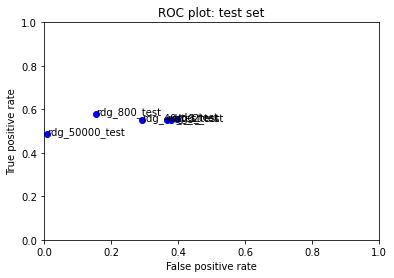

In [65]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [rdg_performance_test, rdg_2_performance_test, rdg_3_performance_test, rdg_40_performance_test, rdg_800_performance_test, rdg_50000_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

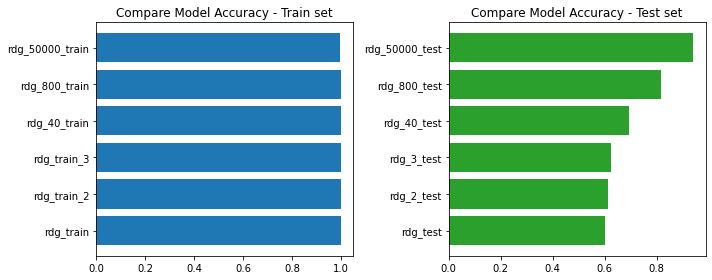

In [68]:
#### Following code is taken from Heew's (kimh585) notebook 

fits = [rdg_performance_train,rdg_2_performance_train, rdg_3_performance_train, rdg_40_performance_train, rdg_800_performance_train, rdg_50000_performance_train]
fits2 = [rdg_performance_test, rdg_2_performance_test, rdg_3_performance_test, rdg_40_performance_test, rdg_800_performance_test, rdg_50000_performance_test]


plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
for fit in fits:
    plt.barh(fit.desc, fit.performance_measures['Accuracy'], color=['tab:blue'])
    plt.title('Compare Model Accuracy - Train set')

plt.subplot(1, 2, 2)
for fit in fits2:
    plt.barh(fit.desc, fit.performance_measures['Accuracy'], color=['tab:green'])
    plt.title('Compare Model Accuracy - Test set')
    
    
plt.tight_layout()
plt.show()